### **New Alternative Model**

This is the model setup, optimiation, and evalution of the new model based on the newly bought data.

*Note: For improved readability, this is the first of two notebooks*




## **Setup**

Setting up libraries and loading dataframe

In [1]:
# Install cuml for GPU processing
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.2/581.2 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 MB 108.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 195.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.5/366.5 MB 110.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 170.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cusparse-cu12
    Found existing installation: nvidia-cusparse-cu12 12.5.4.2
    Uninstalling nvidia-cusparse-cu12-12.5.4.2:
      Successfully uninstalled nvidia-cusparse-cu12-12.5.4.2
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.7.77
    Uninstalling nvidia-curand-cu12-10.3.7.77:
      Successfully uninstalled nvidia-curand-cu12-10.3.7.77
  Attempting uni

In [2]:
# Loading all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit # Like train_test_split but for time series data

# Preprocessing
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline


# Import models
from sklearn.dummy import DummyClassifier
from cuml.svm import SVC # SVC needs cuml for its GPU. Sklearn CPU processing is not fast enough.
from cuml.ensemble import RandomForestClassifier # cuml for faster processing
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, PoissonRegressor
from sklearn.linear_model import SGDClassifier

# Sampling
from sklearn.kernel_approximation import RBFSampler
from sklearn.calibration import CalibratedClassifierCV

# Import evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, f1_score, confusion_matrix,
                            classification_report, roc_curve, auc, roc_auc_score)
from sklearn.model_selection import cross_validate, cross_val_predict

# For optimization
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real


# Random Seed
seed = 42

In [3]:
# Load dataset
url='https://drive.google.com/file/d/1df3HKtpV0YCsf3uiQ6mgmptk0dn4Xtev/view?usp=share_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.columns

Index(['Date', 'Div_enc', 'HomeTeam_enc', 'AwayTeam_enc', 'Season', 'Over2.5',
       'AvgH', 'AvgD', 'AvgA', 'Avg>2.5', 'Avg<2.5', 'AHh', 'AvgAHH', 'AvgAHA',
       'AvgCH', 'AvgCD', 'AvgCA', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'AvgCAHH',
       'AvgCAHA', 'avg_goals_scored_home_5', 'avg_goals_conceded_home_5',
       'avg_shots_home_5', 'avg_shots_on_target_home_5', 'avg_fouls_home_5',
       'avg_corners_home_5', 'avg_yellow_cards_home_5', 'avg_red_cards_home_5',
       'avg_goals_scored_away_5', 'avg_goals_conceded_away_5',
       'avg_shots_away_5', 'avg_shots_on_target_away_5', 'avg_fouls_away_5',
       'avg_corners_away_5', 'avg_yellow_cards_away_5', 'avg_red_cards_away_5',
       'avg_total_goals_home_5', 'avg_total_goals_away_5', 'win_rate_home_5',
       'win_rate_away_5', 'Over2.5_home_5', 'Over2.5_away_5',
       'gd_last_game_home', 'gd_last_game_away', 'recent_goal_trend_home',
       'recent_goal_trend_away', 'recent_hs_trend_home',
       'recent_hs_trend_away', 'recent_as

In [4]:
# Cyclical encoding
# For observing possible time trends within the data
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
print(df['Year'].unique())

df["Day_sin"] = np.sin(2 * np.pi * df["Day"] / 24)
df["Day_cos"] = np.cos(2 * np.pi * df["Day"] / 24)

df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 7)
df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 7)

df["Year_sin"] = np.sin(2 * np.pi * df["Year"] / 12)
df["Year_cos"] = np.cos(2 * np.pi * df["Year"] / 12)

df = df.drop(['Date', 'Day', 'Month', 'Year'], axis=1)
print(df.columns)

[2019 2020 2021 2022 2023 2024 2025]
Index(['Div_enc', 'HomeTeam_enc', 'AwayTeam_enc', 'Season', 'Over2.5', 'AvgH',
       'AvgD', 'AvgA', 'Avg>2.5', 'Avg<2.5', 'AHh', 'AvgAHH', 'AvgAHA',
       'AvgCH', 'AvgCD', 'AvgCA', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'AvgCAHH',
       'AvgCAHA', 'avg_goals_scored_home_5', 'avg_goals_conceded_home_5',
       'avg_shots_home_5', 'avg_shots_on_target_home_5', 'avg_fouls_home_5',
       'avg_corners_home_5', 'avg_yellow_cards_home_5', 'avg_red_cards_home_5',
       'avg_goals_scored_away_5', 'avg_goals_conceded_away_5',
       'avg_shots_away_5', 'avg_shots_on_target_away_5', 'avg_fouls_away_5',
       'avg_corners_away_5', 'avg_yellow_cards_away_5', 'avg_red_cards_away_5',
       'avg_total_goals_home_5', 'avg_total_goals_away_5', 'win_rate_home_5',
       'win_rate_away_5', 'Over2.5_home_5', 'Over2.5_away_5',
       'gd_last_game_home', 'gd_last_game_away', 'recent_goal_trend_home',
       'recent_goal_trend_away', 'recent_hs_trend_home',
       'rece

In [5]:
# Splitting into feature and target groups
target = 'Over2.5'
X = df.drop(target, axis=1)
y = df[target]

# Create cross validation split, taking into account time
time_split = TimeSeriesSplit(n_splits=10)

# Verifying if it's functional
for fold, (train_idx, test_idx) in enumerate(time_split.split(X)):
    print(f"Fold {fold+1}")
    print("Train:", train_idx, "Test:", test_idx)

Fold 1
Train: [   0    1    2 ... 3873 3874 3875] Test: [3876 3877 3878 ... 7739 7740 7741]
Fold 2
Train: [   0    1    2 ... 7739 7740 7741] Test: [ 7742  7743  7744 ... 11605 11606 11607]
Fold 3
Train: [    0     1     2 ... 11605 11606 11607] Test: [11608 11609 11610 ... 15471 15472 15473]
Fold 4
Train: [    0     1     2 ... 15471 15472 15473] Test: [15474 15475 15476 ... 19337 19338 19339]
Fold 5
Train: [    0     1     2 ... 19337 19338 19339] Test: [19340 19341 19342 ... 23203 23204 23205]
Fold 6
Train: [    0     1     2 ... 23203 23204 23205] Test: [23206 23207 23208 ... 27069 27070 27071]
Fold 7
Train: [    0     1     2 ... 27069 27070 27071] Test: [27072 27073 27074 ... 30935 30936 30937]
Fold 8
Train: [    0     1     2 ... 30935 30936 30937] Test: [30938 30939 30940 ... 34801 34802 34803]
Fold 9
Train: [    0     1     2 ... 34801 34802 34803] Test: [34804 34805 34806 ... 38667 38668 38669]
Fold 10
Train: [    0     1     2 ... 38667 38668 38669] Test: [38670 38671 38672 

## **Data Exploration**

Searching for distributions of features

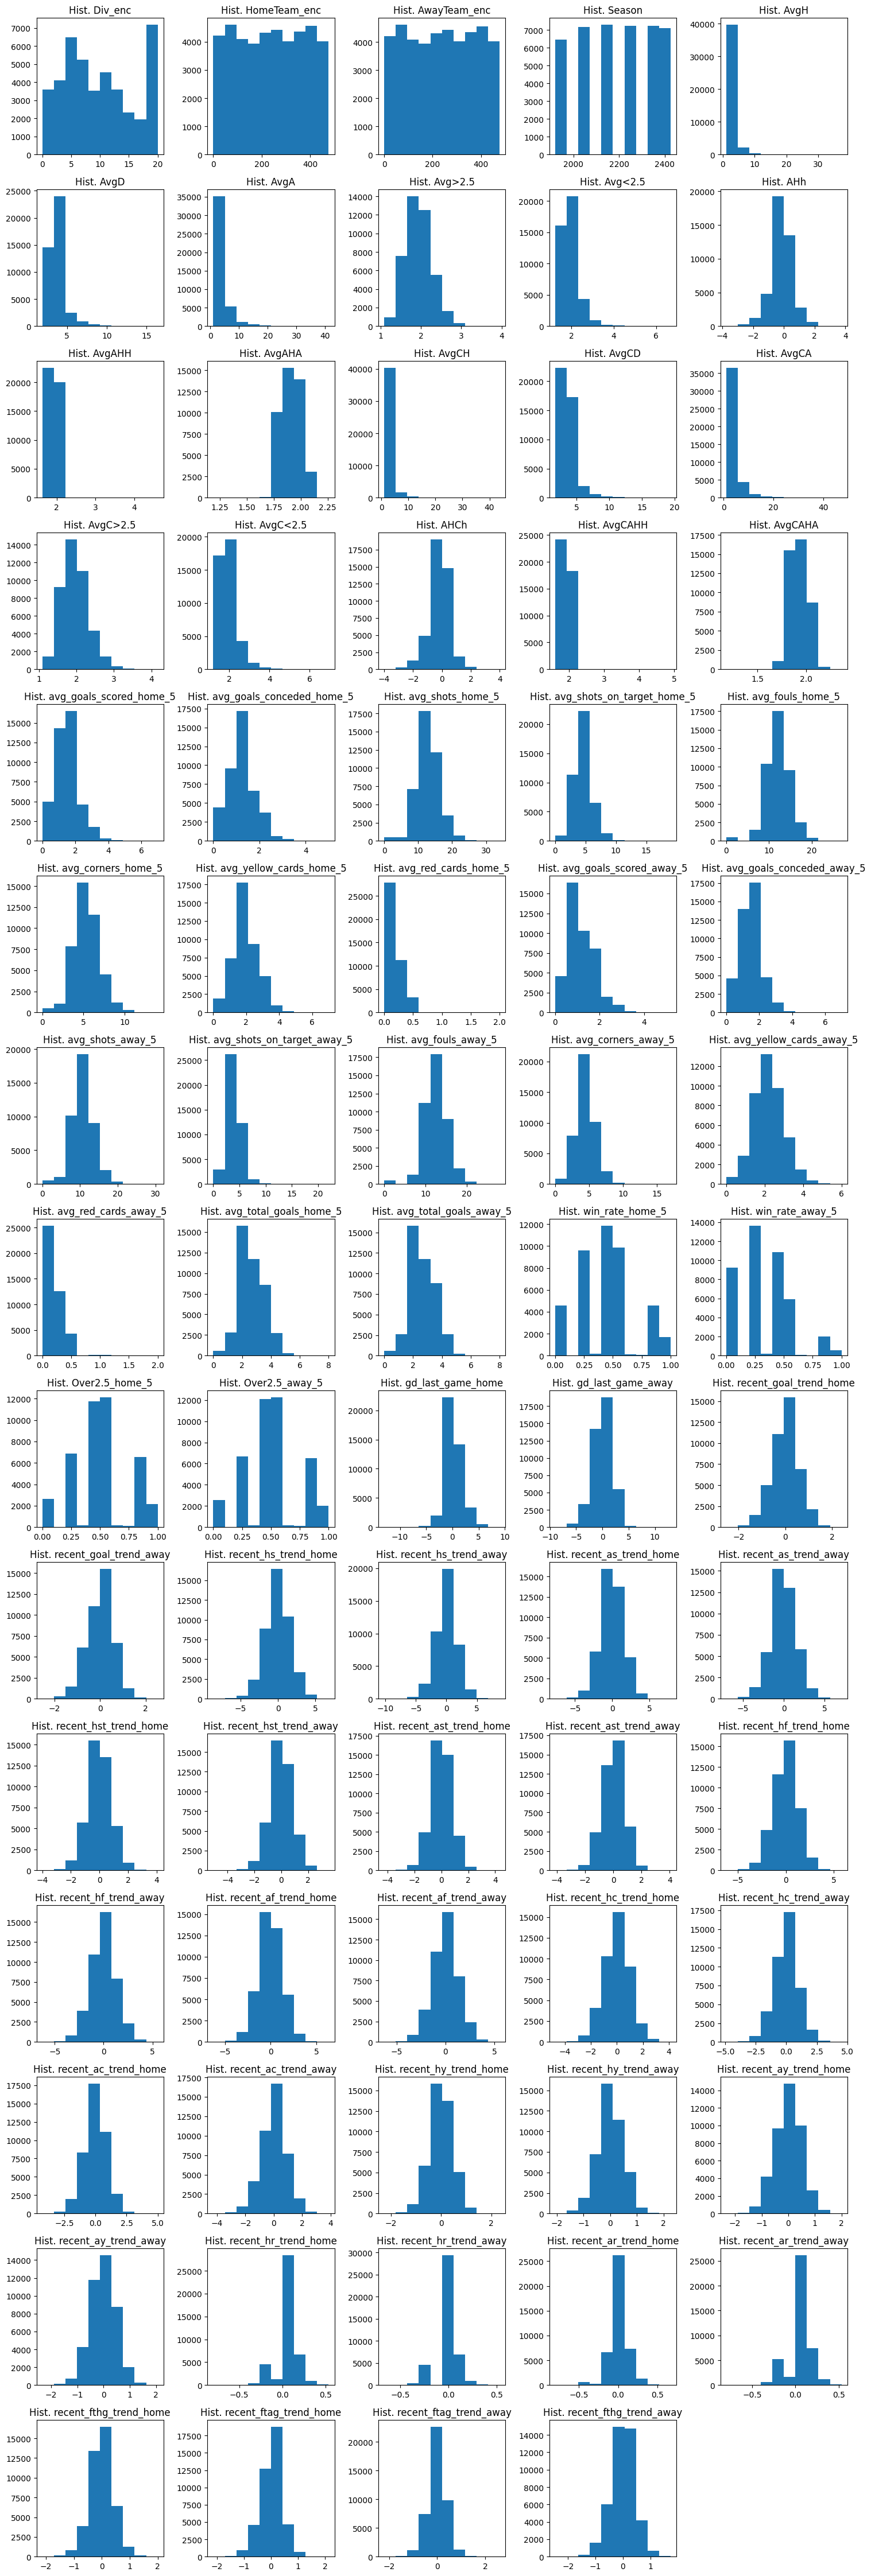

In [6]:


features = ['Div_enc', 'HomeTeam_enc', 'AwayTeam_enc', 'Season', 'AvgH', 'AvgD',
       'AvgA', 'Avg>2.5', 'Avg<2.5', 'AHh', 'AvgAHH', 'AvgAHA', 'AvgCH',
       'AvgCD', 'AvgCA', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'AvgCAHH', 'AvgCAHA',
       'avg_goals_scored_home_5', 'avg_goals_conceded_home_5',
       'avg_shots_home_5', 'avg_shots_on_target_home_5', 'avg_fouls_home_5',
       'avg_corners_home_5', 'avg_yellow_cards_home_5', 'avg_red_cards_home_5',
       'avg_goals_scored_away_5', 'avg_goals_conceded_away_5',
       'avg_shots_away_5', 'avg_shots_on_target_away_5', 'avg_fouls_away_5',
       'avg_corners_away_5', 'avg_yellow_cards_away_5', 'avg_red_cards_away_5',
       'avg_total_goals_home_5', 'avg_total_goals_away_5', 'win_rate_home_5',
       'win_rate_away_5', 'Over2.5_home_5', 'Over2.5_away_5',
       'gd_last_game_home', 'gd_last_game_away', 'recent_goal_trend_home',
       'recent_goal_trend_away', 'recent_hs_trend_home',
       'recent_hs_trend_away', 'recent_as_trend_home', 'recent_as_trend_away',
       'recent_hst_trend_home', 'recent_hst_trend_away',
       'recent_ast_trend_home', 'recent_ast_trend_away',
       'recent_hf_trend_home', 'recent_hf_trend_away', 'recent_af_trend_home',
       'recent_af_trend_away', 'recent_hc_trend_home', 'recent_hc_trend_away',
       'recent_ac_trend_home', 'recent_ac_trend_away', 'recent_hy_trend_home',
       'recent_hy_trend_away', 'recent_ay_trend_home', 'recent_ay_trend_away',
       'recent_hr_trend_home', 'recent_hr_trend_away', 'recent_ar_trend_home',
       'recent_ar_trend_away', 'recent_fthg_trend_home',
       'recent_ftag_trend_home', 'recent_ftag_trend_away',
       'recent_fthg_trend_away']

# Creating grid space for nice plotting
num_plots = len(features)
cols = 5
rows = -(-num_plots // cols)  # Ceiling division to fit all plots

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Flatten axes for easy iteration
axes = axes.flatten()

for i in range(num_plots): # Make histogram plots
    ax = axes[i]
    ax.hist(X[features[i]])  # Create histogram
    ax.set_title(f"Hist. {features[i]}") # Titles

# Hide any unused subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## **Model Preprocessing**
 This performs transformations on all data with Poisson Distribution, removing skewness to make them more Normal.   



**Note:**
*Currently everything is hardcoded to use poisson_sqrt_transform, but the optimizers can feel free to experiment with trying poisson_log_transform.*

In [7]:
def poisson_sqrt_transform(X):
  """
  Applies square root transformation to specified features.

  Args:
    X: pandas DataFrame containing the features.

  Returns:
    pandas DataFrame: Data with specified features square root transformed.
  """

  # Features with Poisson Distribution (based on your previous analysis)
  poisson_features = ['AvgH', 'AvgD',
        'AvgA', 'Avg>2.5', 'Avg<2.5', 'AvgAHH', 'AvgAHA', 'AvgCH',
        'AvgCD', 'AvgCA', 'AvgC>2.5', 'AvgC<2.5', 'AvgCAHH', 'AvgCAHA',
        'avg_goals_scored_home_5', 'avg_goals_conceded_home_5',
        'avg_shots_home_5', 'avg_shots_on_target_home_5', 'avg_fouls_home_5',
        'avg_corners_home_5', 'avg_yellow_cards_home_5', 'avg_red_cards_home_5',
        'avg_goals_scored_away_5', 'avg_goals_conceded_away_5',
        'avg_shots_away_5', 'avg_shots_on_target_away_5', 'avg_fouls_away_5',
        'avg_corners_away_5', 'avg_yellow_cards_away_5', 'avg_red_cards_away_5',
        'avg_total_goals_home_5', 'avg_total_goals_away_5']

  X_transformed = X.copy()

  # SQRT Transform for Poisson Skewness
  for feature in poisson_features:
      if feature in X_transformed.columns:
          # Add a small constant to avoid taking the square root of negative numbers if any exist
          X_transformed[feature] = np.sqrt(X_transformed[feature].clip(lower=0))


  return X_transformed


def poisson_log_transform(X):
  """
  Applies square root transformation to specified features.

  Args:
    X: pandas DataFrame containing the features.

  Returns:
    pandas DataFrame: Data with specified features log transformed.
  """

  # Features with Poisson Distribution (based on your previous analysis)
  poisson_features = ['AvgH', 'AvgD',
        'AvgA', 'Avg>2.5', 'Avg<2.5', 'AvgAHH', 'AvgAHA', 'AvgCH',
        'AvgCD', 'AvgCA', 'AvgC>2.5', 'AvgC<2.5', 'AvgCAHH', 'AvgCAHA',
        'avg_goals_scored_home_5', 'avg_goals_conceded_home_5',
        'avg_shots_home_5', 'avg_shots_on_target_home_5', 'avg_fouls_home_5',
        'avg_corners_home_5', 'avg_yellow_cards_home_5', 'avg_red_cards_home_5',
        'avg_goals_scored_away_5', 'avg_goals_conceded_away_5',
        'avg_shots_away_5', 'avg_shots_on_target_away_5', 'avg_fouls_away_5',
        'avg_corners_away_5', 'avg_yellow_cards_away_5', 'avg_red_cards_away_5',
        'avg_total_goals_home_5', 'avg_total_goals_away_5']

  X_transformed = X.copy()
  X_transformed = pd.DataFrame(X_transformed)

  # SQRT Transform for Poisson Skewness
  for feature in poisson_features:
      if feature in X_transformed.columns:
          # Add a small constant to avoid taking the square root of negative numbers if any exist
          X_transformed[feature] = np.log1p(X_transformed[feature].clip(lower=0))


  return X_transformed

# **Instantiate Models**

Testing out multiple models:

*   Dummy Classifier
*   Random Forest
*   SVM with Stochastic Gradient Descent
*   SVM (and the Kernels)
*   Logistic Classification





In [8]:
# Dummy Classifer
dummy = DummyClassifier(strategy='most_frequent')



In [9]:
# Random Forest Classifier
forest = RandomForestClassifier(n_estimators=500, random_state=seed, max_features='sqrt', max_depth=5)


In [10]:
# Linear SVM using SGDC
SGDC_pipe = Pipeline([
    ("poisson_sqrt", FunctionTransformer(poisson_sqrt_transform, validate=False)),
    ("scaler", StandardScaler()),
    ("calibrated_sgd", CalibratedClassifierCV( # To fit SVM to ROC plot, it must be wrapped in calibrater
        SGDClassifier(max_iter=1000, tol=1e-3,
            random_state=seed,
            class_weight='balanced'
        ),
        cv=5,
        method="sigmoid"
    ))
])


In [11]:
# SVM with RBF Kernel
rbf_pipe = Pipeline([
    ("poisson_sqrt", FunctionTransformer(poisson_sqrt_transform, validate=False)),
    ("scaler", StandardScaler()),
    ("calibrated_sgd", CalibratedClassifierCV( # To fit SVM to ROC plot, it must be wrapped in calibrater
        SVC(kernel='rbf', random_state=seed),
        cv=5,
        method="sigmoid"
    ))
])

In [12]:
# SVM with poly kernel
poly_pipe = Pipeline([
    ("poisson_sqrt", FunctionTransformer(poisson_sqrt_transform, validate=False)),
    ("scaler", StandardScaler()),
    ("calibrated_sgd", CalibratedClassifierCV( # To fit SVM to ROC plot, it must be wrapped in calibrater
        SVC(kernel='poly', random_state=seed),
        cv=5,
        method="sigmoid"
    ))
])

In [13]:
# Logistic Regression
log_pipe = Pipeline([
    ('poisson_sqrt', FunctionTransformer(poisson_sqrt_transform, validate=False)),
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(random_state=seed))
])


### **Evaluate Performance of Models**
**performance_metrics(model):** Shows classification metrics + plots ROC AUC curve. Used only for getting a general sense of model performance BEFORE tuning, THEN used for final evaluation AFTER tuning. DO NOT USE FOR TUNING/OPTIMIZATION.  
  

**time_series_cv(X, y, n_splits=10):** This function simply for performing the TimeSeriesSplit on crossvalidation searches (e.g. GridSearchCV, example below).  


In [14]:
# Performance Evaluation Function
'''
Shows the performance of the model with accuracy, precision, recall, F1, and ROC/AUC

Parameters{
  model: the model to evaluate (mandatory)
  scaled: whether or not to scale the data internally (optional)(default=True)
}

Returns{
  None
}

'''

def performance_metrics(model):
  accuracy_scores = [] # On test
  f1_scores = []
  precision_scores = []
  recall_scores = []
  all_y_test = []
  all_y_pred_proba = []

  accuracy_scores_train = [] # On train
  f1_scores_train = []
  precision_scores_train = []
  recall_scores_train = []
  all_y_train= []
  all_y_pred_proba_train = []

  for train_index, test_index in time_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


  # Fit the model
  model.fit(X_train, y_train)

  # Get predictions
  y_pred_test = model.predict(X_test)
  # Check if the model has predict_proba and if it returns probabilities for both classes
  if hasattr(model, 'predict_proba') and model.predict_proba(X_test).shape[1] > 1:
    if type(model.predict_proba(X_test)) == np.ndarray:
      y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    else:
      y_pred_proba_test = model.predict_proba(X_test).to_numpy()[:, 1]
  else:
    # If not, use the prediction as probability for class 1 (assuming binary classification)
    y_pred_proba_test = y_pred_test

  y_pred_train = model.predict(X_train)
  if hasattr(model, 'predict_proba') and model.predict_proba(X_train).shape[1] > 1:
    if type(model.predict_proba(X_train)) == np.ndarray:
      y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    else:
      y_pred_proba_train = model.predict_proba(X_train).to_numpy()[:, 1]
  else:
    y_pred_proba_train = y_pred_train


  # Calculate metrics for the current fold
  accuracy_scores = accuracy_score(y_test, y_pred_test) # On test
  f1_scores = f1_score(y_test, y_pred_test)
  precision_scores = precision_score(y_test, y_pred_test)
  recall_scores = recall_score(y_test, y_pred_test)

  accuracy_scores_train = accuracy_score(y_train, y_pred_train) # On train
  f1_scores_train = f1_score(y_train, y_pred_train)
  precision_scores_train = precision_score(y_train, y_pred_train)
  recall_scores_train = recall_score(y_train, y_pred_train)

  # Store true labels and predicted probabilities for ROC AUC
  all_y_test.extend(y_test) # On test
  all_y_pred_proba.extend(y_pred_proba_test)

  all_y_train.extend(y_train) # On train
  all_y_pred_proba_train.extend(y_pred_proba_train)


  # Print average evaluation scores across all folds
  print(f'Test Performance (Average across Time Series Splits):')
  print(f'Accuracy: {np.mean(accuracy_scores)}')
  print(f'F1: {np.mean(f1_scores)}')
  print(f'Precision: {np.mean(precision_scores)}')
  print(f'Recall: {np.mean(recall_scores)}')

  print(f'\nTrain Performance (Average across Time Series Splits):')
  print(f'Accuracy: {np.mean(accuracy_scores_train)}')
  print(f'F1: {np.mean(f1_scores_train)}')
  print(f'Precision: {np.mean(precision_scores_train)}')
  print(f'Recall: {np.mean(recall_scores_train)}')

  # Plot ROC Curve using concatenated predictions
  # Only attempt to plot ROC if the model has predict_proba and it was used
  if hasattr(model, 'predict_proba') and model.predict_proba(X_test).shape[1] > 1:
    fpr, tpr, thresholds = roc_curve(all_y_test, all_y_pred_proba)
    roc_auc = auc(fpr, tpr)
    fpr_train, tpr_train, thresholds = roc_curve(all_y_train, all_y_pred_proba_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    plt.figure()
    plt.plot(fpr, tpr, label='Test ROC curve (area = %0.2f)' % roc_auc)
    plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test ROC Curve (Average across Time Series Splits)')
    plt.legend()
    plt.show()
  else:
    print("\nROC curve cannot be plotted for this model as it does not have predict_proba or does not return probabilities for both classes.")


def time_series_cv(X, y, n_splits=10):
  """
  Generates train and test indices for time series cross-validation.

  Args:
    X: Features.
    y: Target.
    n_splits: Number of splits.

  Yields:
    train_index: Indices for the training set.
    test_index: Indices for the test set.
  """
  time_split = TimeSeriesSplit(n_splits=n_splits)
  for train_index, test_index in time_split.split(X):
    yield train_index, test_index

print(list(time_series_cv(X, y)))

[(array([   0,    1,    2, ..., 3873, 3874, 3875]), array([3876, 3877, 3878, ..., 7739, 7740, 7741])), (array([   0,    1,    2, ..., 7739, 7740, 7741]), array([ 7742,  7743,  7744, ..., 11605, 11606, 11607])), (array([    0,     1,     2, ..., 11605, 11606, 11607]), array([11608, 11609, 11610, ..., 15471, 15472, 15473])), (array([    0,     1,     2, ..., 15471, 15472, 15473]), array([15474, 15475, 15476, ..., 19337, 19338, 19339])), (array([    0,     1,     2, ..., 19337, 19338, 19339]), array([19340, 19341, 19342, ..., 23203, 23204, 23205])), (array([    0,     1,     2, ..., 23203, 23204, 23205]), array([23206, 23207, 23208, ..., 27069, 27070, 27071])), (array([    0,     1,     2, ..., 27069, 27070, 27071]), array([27072, 27073, 27074, ..., 30935, 30936, 30937])), (array([    0,     1,     2, ..., 30935, 30936, 30937]), array([30938, 30939, 30940, ..., 34801, 34802, 34803])), (array([    0,     1,     2, ..., 34801, 34802, 34803]), array([34804, 34805, 34806, ..., 38667, 38668, 3

Test Performance (Average across Time Series Splits):
Accuracy: 0.49120538023797206
F1: 0.0
Precision: 0.0
Recall: 0.0

Train Performance (Average across Time Series Splits):
Accuracy: 0.5014222911817947
F1: 0.0
Precision: 0.0
Recall: 0.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


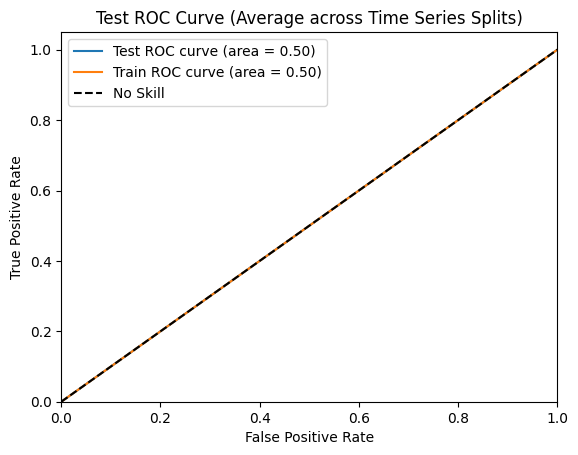

In [15]:
# Dummy Performance
performance_metrics(dummy)

Test Performance (Average across Time Series Splits):
Accuracy: 0.5747542679772375
F1: 0.5532608695652174
Precision: 0.5942790426152949
Recall: 0.5175394001016776

Train Performance (Average across Time Series Splits):
Accuracy: 0.5864753038531161
F1: 0.5590271075200618
Precision: 0.5968321262438909
Recall: 0.5257261410788382


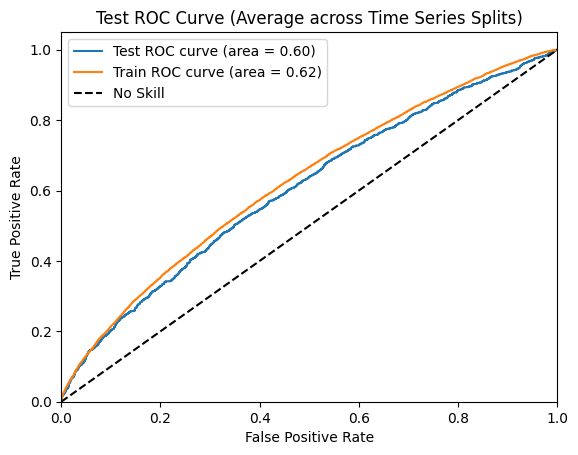

In [16]:
# Random Forest Performance
performance_metrics(forest)


Test Performance (Average across Time Series Splits):
Accuracy: 0.5716502845318159
F1: 0.5560321715817694
Precision: 0.5882019285309132
Recall: 0.527198779867819

Train Performance (Average across Time Series Splits):
Accuracy: 0.5762348073441944
F1: 0.5612466197220809
Precision: 0.5800542365377165
Recall: 0.5436203319502074


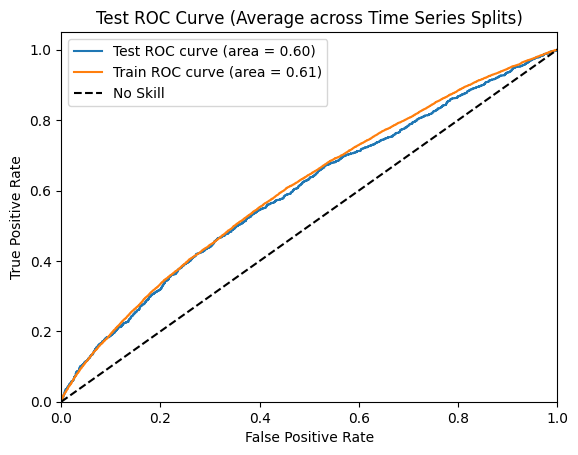

In [17]:
# SVM SGDC
performance_metrics(SGDC_pipe)

Test Performance (Average across Time Series Splits):
Accuracy: 0.5760475944128298
F1: 0.591984067712223
Precision: 0.58
Recall: 0.6044738179969497

Train Performance (Average across Time Series Splits):
Accuracy: 0.6964572019653478
F1: 0.6852408023168508
Precision: 0.7093604263824117
Recall: 0.662707468879668


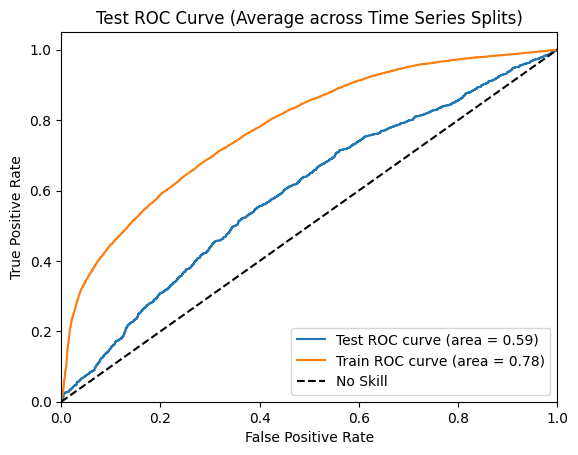

In [18]:
# SVM RBF
performance_metrics(rbf_pipe)

Test Performance (Average across Time Series Splits):
Accuracy: 0.5556130367304708
F1: 0.5553830227743272
Precision: 0.5656299420137059
Recall: 0.5455007625826132

Train Performance (Average across Time Series Splits):
Accuracy: 0.7757951900698216
F1: 0.7632441288913162
Precision: 0.8059400230680508
Recall: 0.7248443983402489


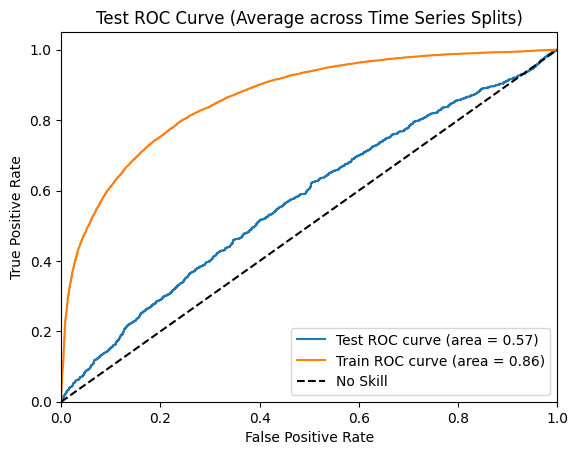

In [19]:
# SVM Poly
performance_metrics(poly_pipe)

Test Performance (Average across Time Series Splits):
Accuracy: 0.5732022762545267
F1: 0.5729813664596274
Precision: 0.5835529783869268
Recall: 0.5627859684799187

Train Performance (Average across Time Series Splits):
Accuracy: 0.582311869666408
F1: 0.5670633644258604
Precision: 0.5867539383181717
Recall: 0.5486514522821577


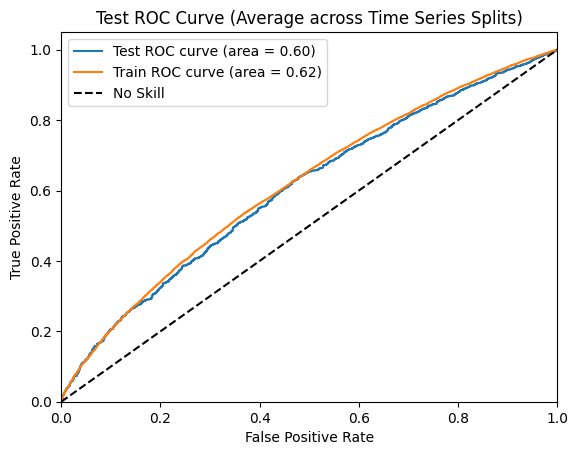

In [20]:
# Logistic Performance
performance_metrics(log_pipe)

# **Optimized Models**

### Performing RandomizedSearchCV

In [30]:
param_grid_forest = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 10, 15, 20]
}

grid_forest = GridSearchCV(forest, param_grid=param_grid_forest, cv=time_series_cv(X, y), scoring='accuracy', n_jobs=-1) # Use original X and y, it will be processed by time_series_cv()
grid_forest.fit(X,y)
print(grid_forest.best_params_) # Best found parameters

{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 10}


In [37]:
'''
IMPORTANT:
This optimizer is too computationally intensive for us.
This is purely just what it would look like. We do not recommend running it.
'''

# Define the search spaces for the RBF SVM
#rbf_search_spaces = {
#    'calibrated_sgd__estimator__C': Real(1e-6, 1e+6, prior='log-uniform'),
#    'calibrated_sgd__estimator__gamma': Real(1e-6, 1e+1, prior='log-uniform')
#}

# Instantiate BayesSearchCV for the RBF SVM pipeline
#bayes_rbf = BayesSearchCV(
#    estimator=rbf_pipe,
#    search_spaces=rbf_search_spaces,
#    n_iter=5,  # Low number of iterations as this is a very slow to run model
#    cv=time_series_cv(X, y), # Use the time series cross-validation
#    scoring='accuracy',
#    n_jobs=-1,  # Use all available CPU cores
#    random_state=seed,
#    verbose=1
#)

# Fit BayesSearchCV
#bayes_rbf.fit(X, y)

# Print the best found parameters
#print("Best parameters for RBF SVM:", bayes_rbf.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


KeyboardInterrupt: 

In [35]:
# Define the search spaces for SGDC parameters
sgdc_search_spaces = {
    'calibrated_sgd__estimator__loss': Categorical(['log_loss', 'hinge']),
    'calibrated_sgd__estimator__alpha': Real(1e-6, 1e-1, prior='log-uniform')
}

# Instantiate BayesSearchCV for the SGDC pipeline
bayes_sgdc = BayesSearchCV(
    estimator=SGDC_pipe,
    search_spaces=sgdc_search_spaces,
    n_iter=32,  # More iterations for this one since it is much faster
    cv=time_series_cv(X, y), # Use the time series cross-validation
    scoring='accuracy',
    n_jobs=-1,  # Use all available CPU cores
    random_state=seed,
    verbose=1
)

# Fit BayesSearchCV
bayes_sgdc.fit(X, y.values)

# Print the best found parameters
print("Best parameters for SGDClassifier:", bayes_sgdc.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [ ]:
# Optimization of Logistic Regression
param_grid_log = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100],
    'log_reg__penalty': ['l1', 'l2'],
    'log_reg__max_iter': [1000, 2000]
}
grid_log = GridSearchCV(log_pipe, param_grid=param_grid_log, cv=time_series_cv(X, y), scoring='accuracy', n_jobs=-1) # Use original X and y
grid_log.fit(X,y)
print(grid_log.best_params_) # Best found parameters

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, *

{'log_reg__C': 10, 'log_reg__max_iter': 1000, 'log_reg__penalty': 'l2'}


### Instantiate Models with New Params

In [ ]:
# Random Forest Classifier
forest_optimized = RandomForestClassifier(n_estimators=100, random_state=seed, max_features='sqrt', max_depth=5)



In [ ]:
# SVM with RBF Kernel
rbf_pipe_optimized = Pipeline([
    ("poisson_sqrt", FunctionTransformer(poisson_sqrt_transform, validate=False)),
    ("scaler", StandardScaler()),
    ("calibrated_sgd", CalibratedClassifierCV( # To fit SVM to ROC plot, it must be wrapped in calibrater
        SVC(kernel='rbf', C=0.01, gamma=0.001),
        cv=5,
        method="sigmoid"
    ))
])

In [ ]:
# Linear SVM using SGDC
SGDC_pipe_optimized = Pipeline([
    ("poisson_sqrt", FunctionTransformer(poisson_sqrt_transform, validate=False)),
    ("scaler", StandardScaler()),
    ("calibrated_sgd", CalibratedClassifierCV( # To fit SVM to ROC plot, it must be wrapped in calibrater
        SGDClassifier(max_iter=1000, tol=1e-3,
            random_state=seed,
            class_weight='balanced',
            alpha=0.01,
            loss='hinge'
        ),
        cv=5,
        method="sigmoid"
    ))
])


In [ ]:
# Logistic Regression
log_pipe_optimized = Pipeline([
    ('poisson_sqrt', FunctionTransformer(poisson_sqrt_transform, validate=False)),
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(random_state=seed, C=10, max_iter=1000, penalty='l2'))
])


### Show Optimized Results

Test Performance (Average across Time Series Splits):
Accuracy: 0.5685463010863943
F1: 0.5450081833060556
Precision: 0.5879929370217775
Recall: 0.5078800203355364

Train Performance (Average across Time Series Splits):
Accuracy: 0.5861908456167572
F1: 0.5564118201474746
Precision: 0.5975943789448612
Recall: 0.520539419087137


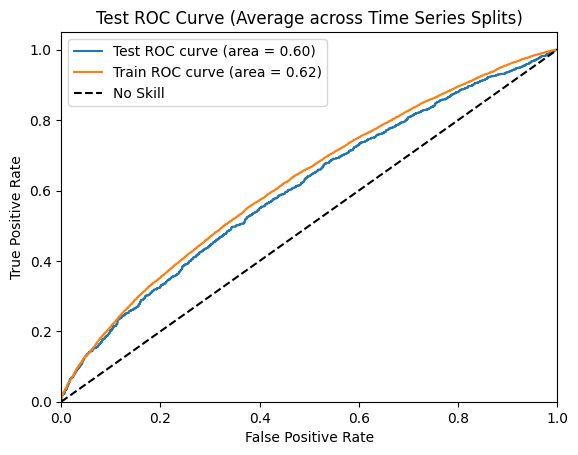

In [ ]:
performance_metrics(forest_optimized)

Test Performance (Average across Time Series Splits):
Accuracy: 0.5724262803931712
F1: 0.576696542893726
Precision: 0.5810113519091847
Recall: 0.57244534824606

Train Performance (Average across Time Series Splits):
Accuracy: 0.578174295319369
F1: 0.5570280252009558
Precision: 0.5845873233014136
Recall: 0.5319502074688797


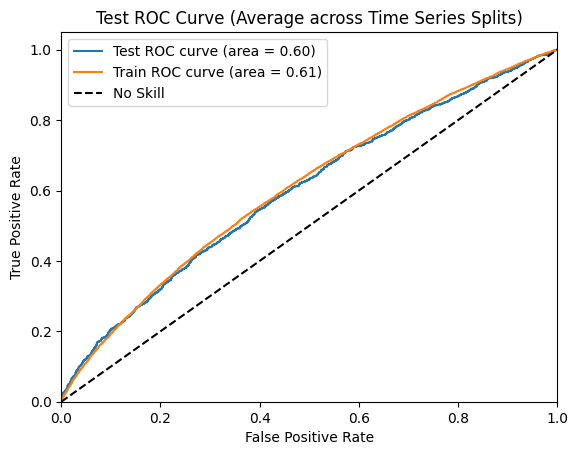

In [ ]:
#performance_metrics(rbf_pipe_optimized)

Test Performance (Average across Time Series Splits):
Accuracy: 0.5716502845318159
F1: 0.5560321715817694
Precision: 0.5882019285309132
Recall: 0.527198779867819

Train Performance (Average across Time Series Splits):
Accuracy: 0.5762348073441944
F1: 0.5612466197220809
Precision: 0.5800542365377165
Recall: 0.5436203319502074


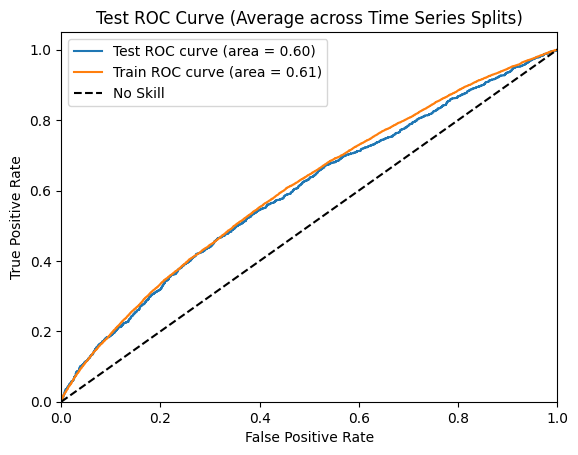

In [ ]:
performance_metrics(SGDC_pipe_optimized)

Test Performance (Average across Time Series Splits):
Accuracy: 0.5732022762545267
F1: 0.5729813664596274
Precision: 0.5835529783869268
Recall: 0.5627859684799187

Train Performance (Average across Time Series Splits):
Accuracy: 0.582311869666408
F1: 0.5668776145017698
Precision: 0.5868310015545192
Recall: 0.5482365145228216


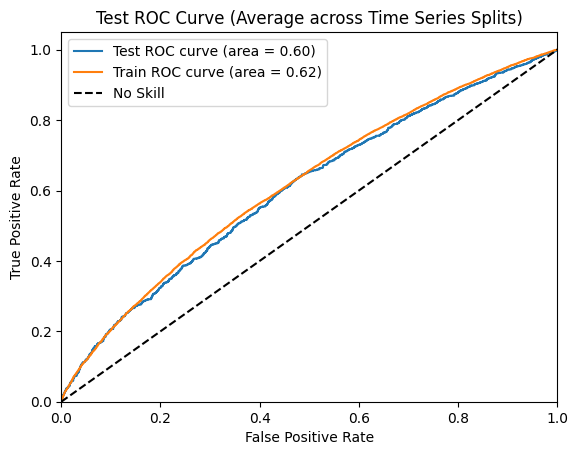

In [ ]:
performance_metrics(log_pipe_optimized)

# Summary


*   We did extra data exploration and preprocessing that may have been missed earlier.
*   Then we created a function for evaluating and plotting these models.
*   We tried to train multiple models on default parameters.
*   Then taking the best of those, we tried to do basic optimization.
*   Due to the high performance of Random Forest, we decided that next we will experiment with XGBoost. XGBoost Optimization will be performed on the next notebook.





